In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import agent as ag
import model as ml

from matplotlib import style

from df_helpers import get_rows_between, get_outliers
from google_window import WindowGenerator
from model import get_lstm_model
style.use('dark_background')

import importlib
importlib.reload(ag)
importlib.reload(ml)

In [ ]:
# Open no1_train.csv and no1_validation.csv
original_df_train = pd.read_csv('no1_train.csv')
original_df_test = pd.read_csv('no1_validation.csv')

# Make copies
df_train = original_df_train.copy()
df_test = original_df_test.copy()

In [ ]:
df_train

In [ ]:
df_test.head()

In [ ]:
# Convert timestamps in "start_time" to seconds
df_train['start_time'] = pd.to_datetime(df_train['start_time'])
# Convert datetime into seconds since epoch
df_train['start_time'] = df_train['start_time'].apply(lambda x: x.timestamp())

# Do the same to df_test
df_test['start_time'] = pd.to_datetime(df_test['start_time'])
df_test['start_time'] = df_test['start_time'].apply(lambda x: x.timestamp())

## Exploratory Data Analysis

First let's look at the data and see if we notice any outliers that might not correlate well with the overall trend of the data

In [ ]:
df_train.describe().transpose()

Seeing as river has absolutely all values equal to 0, this is not a good feature to use. We therefore drop it because
it gives no additional information

In [ ]:
df_train = df_train.drop(['river'], axis=1)
df_test = df_test.drop(['river'], axis=1)

Let's visualize the data in several plots to see if we instinctively can see anything that doesn't add up

In [ ]:
# Get column names from df_train except start_time
cols = df_train.columns.drop('start_time')
plot_features = df_train[cols]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# Do the same for df_test
plot_features = df_test.drop("start_time", axis=1)[cols]
plot_features.index = df_test['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

In [ ]:
# Plot two different plots; one for df_train, one for df_test with feature "y"
plot_features = df_train[['y']]
plot_features.index = df_train['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))

# Do the same for df_test, but in a new plot 
plot_features = df_test[['y']]
plot_features.index = df_test['start_time']
_ = plot_features.plot(subplots=True, figsize=(20, 12))


There are some spikes in both datasets, especially the validation data, that seem rather inconsistent. Let's replace them with values based on the mean of the "y" value for other datapoints that have similar "total" feature.

In [ ]:
df1 = get_rows_between(df_train, 'total', 1500, 1550)
df2 = get_rows_between(df1, 'y', -2900, 2900)
mean_val = df2["y"].mean()
q1 = (df_test["y"] > 1000) | (df_test["y"] < -1000)
q2 = (df_train["y"] > 1000) | (df_train["y"] < -1000)
df_test.loc[q1, "y"] = mean_val
df_train.loc[q2, "y"] = mean_val

Let's see if there are any NaN-values present

In [ ]:
# Check for NaN values
df_train.isnull().sum()

## Feature engineering
In this section, we will look at how we can manipulate the data in the dataset in order to better suit it for model prediction. This will include modifying existing features, and introducing new ones.

First we'll implement the required feature: previous_y

Second we'll look at frequencies.
The nature of demand on the power grid is highly dependent on two key factors:
* The time of day
* The time of year

Seeing as the price of electricity has been a heated debate for the past half-year due to environmental and seasonal changes, this might be a good place to start.

In [ ]:
day = 24*60*60
year = (365.2425)*day

df_train['Day sin'] = np.sin(df_train['start_time'] * (2 * np.pi / day))
df_train['Day cos'] = np.cos(df_train['start_time'] * (2 * np.pi / day))
df_train['Year sin'] = np.sin(df_train['start_time'] * (2 * np.pi / year))
df_train['Year cos'] = np.cos(df_train['start_time'] * (2 * np.pi / year))

# Do the same, but for df_test
df_test['Day sin'] = np.sin(df_test['start_time'] * (2 * np.pi / day))
df_test['Day cos'] = np.cos(df_test['start_time'] * (2 * np.pi / day))
df_test['Year sin'] = np.sin(df_test['start_time'] * (2 * np.pi / year))
df_test['Year cos'] = np.cos(df_test['start_time'] * (2 * np.pi / year))


In [ ]:
df_train.head()

In [ ]:
RESOLUTION = 5
N_PREV = 288
START_INDEX = 288
BATCH_SIZE = 32
TARGET = 'y'
EPOCHS = 10
agent = ag.Agent(
    min_scale=0,
    max_scale=1,
    resolution=RESOLUTION,
    n_prev=N_PREV,
    start_index=START_INDEX,
    batch_size=BATCH_SIZE,
    target=TARGET,
    verbose=False
)

In [ ]:
model = get_lstm_model()
df_train = agent.add_previous_y_to_df(df_train, training=True)
df_test = agent.add_previous_y_to_df(df_test, training=False)

In [ ]:
df_train.drop(columns='start_time', inplace=True)
df_test.drop(columns='start_time', inplace=True)

In [ ]:
agent.fit_scalers_to_df(df_train)
history = agent.train(df_train, model=model, epochs=EPOCHS)

In [ ]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')

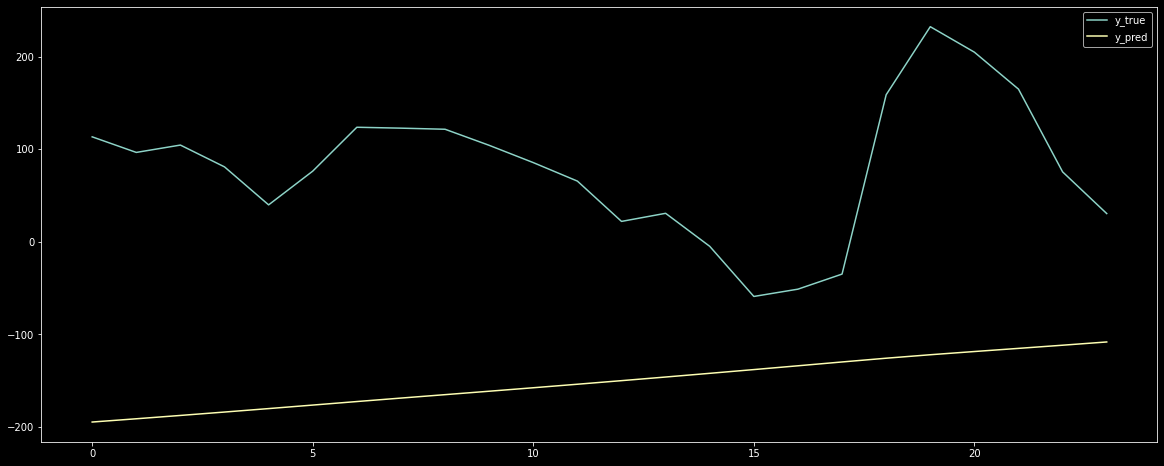

In [78]:
x_valid = df_test.drop("y", axis=1)
y_pred = agent.predict_2hrs(df=x_valid, model=model)
agent.visualize_results(df_test["y"], y_pred)